<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/TCC_PUCMinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data in Space Science



In [19]:
#Importing Librarys
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from keras.models import Sequential
from keras.layers import Activation, Dense
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import time


#Importing Librarys 📚
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time # for time mesurment
import tensorflow as tf
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from IPython.display import HTML

seed = 55
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)


2.11.0


In [1]:
#Monting Google Drive
# https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
#Unziping data-set
!unzip "nasa-nearest-earth-objects.zip" -d "/content/"

!kaggle datasets download -d nasa/kepler-exoplanet-search-results
!unzip "kepler-exoplanet-search-results.zip" -d "/content/"

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
 76% 5.00M/6.60M [00:00<00:00, 35.8MB/s]
100% 6.60M/6.60M [00:00<00:00, 44.1MB/s]
Archive:  nasa-nearest-earth-objects.zip
  inflating: /content/neo.csv        
  inflating: /content/neo_v2.csv     
  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 73.0MB/s]


In [5]:
#Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


In [20]:
df_nasa = pd.read_csv('neo.csv')
df_nasa.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [21]:
features = df_nasa.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
features.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


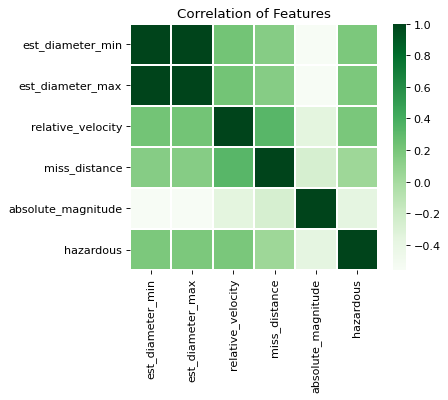

In [22]:
# Correlation Betwenn data
plt.figure(figsize = (5, 4),dpi=80)
plt.title('Correlation of Features')
sns.heatmap(features.astype(float).corr(), linewidths = 0.1, linecolor = 'white', cmap="Greens")
plt.show()

In [ ]:
# df_newfeatures is features without "hazardous"
#df_newfeatures = features.drop('hazardous')
sns.pairplot(features)

In [9]:
#Defining the feature how will be our classify 🎯
targets = features['hazardous']
features = features.drop('hazardous', axis=1)
targets.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [10]:
#Normalize data
scaler = MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
#features.head()

In [11]:
## Split in Traing and Test
x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=42, test_size=0.3)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [12]:
# Model definition
#x_train, x_test, y_train, y_test
#i = 0
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_1 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_1.append(Sequential())
  model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_1[i].add(Dropout(dropo[i]))
  model_NASA_1[i].add(Dense(1, activation='sigmoid'))
  model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

In [14]:
epochs = 100
en_time_NASA_1 = []
st_time_NASA_1 = []
history_NASA_1 = []
for i in range(0,1):
  st_time_NASA_1.append(time.time())
  history_NASA_1.append(
    model_NASA_1[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=1, shuffle=True))
  en_time_NASA_1.append(time.time())

Epoch 1/100
1988/1988 [==============================] - 6s 3ms/step - loss: 0.2017 - accuracy: 0.9058 - val_loss: 0.2037 - val_accuracy: 0.9048
Epoch 2/100
1988/1988 [==============================] - 5s 2ms/step - loss: 0.2015 - accuracy: 0.9059 - val_loss: 0.2039 - val_accuracy: 0.9048
Epoch 3/100
1988/1988 [==============================] - 7s 3ms/step - loss: 0.2015 - accuracy: 0.9061 - val_loss: 0.2035 - val_accuracy: 0.9050
Epoch 4/100
1988/1988 [==============================] - 5s 2ms/step - loss: 0.2014 - accuracy: 0.9060 - val_loss: 0.2035 - val_accuracy: 0.9048
Epoch 5/100
1988/1988 [==============================] - 8s 4ms/step - loss: 0.2013 - accuracy: 0.9062 - val_loss: 0.2034 - val_accuracy: 0.9050
Epoch 6/100
1988/1988 [==============================] - 4s 2ms/step - loss: 0.2012 - accuracy: 0.9060 - val_loss: 0.2035 - val_accuracy: 0.9048
Epoch 7/100
1988/1988 [==============================] - 5s 2ms/step - loss: 0.2010 - accuracy: 0.9062 - val_loss: 0.2038 - val_ac

In [15]:
for i in range(0,1):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_1[i] - st_time_NASA_1[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_1[-1]- st_time_NASA_1[0])/60,4), "minutes TOTAL")  

Model NASA 11
9.3708 minutes

TOTAL
 9.3708 minutes TOTAL


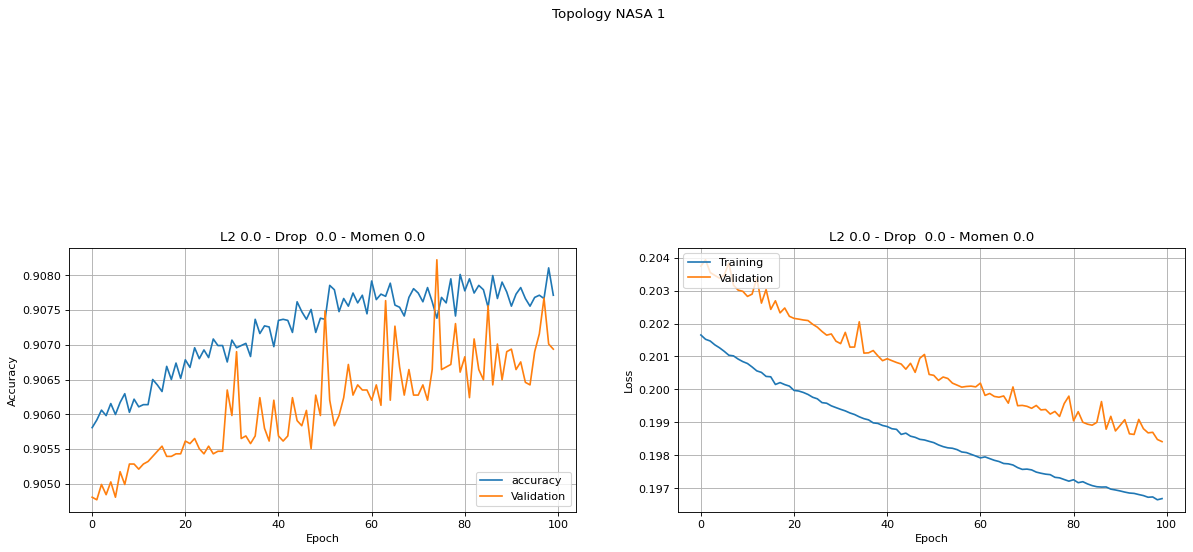

In [16]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 1")
for i in range(0,1):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_1[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_1[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')
  plt.grid()

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_1[i].history['loss'], color="C0")
  plt.plot(    history_NASA_1[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.grid()

plt.show()

852/852 [==============================] - 2s 2ms/step


<Figure size 640x480 with 0 Axes>

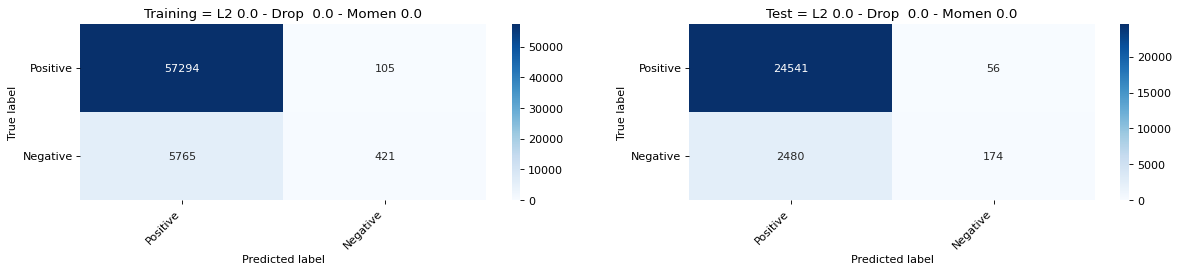

In [17]:



#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('Topology NASA 1')
for i in range(0,1):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_1[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_1[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()